# Thickness estimation for pCO2 Silicone layer

In [1]:
# Import

# Imported from other script(Classification model)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
#import imblearn
#import cv2 as cv

from PIL import Image
import PIL

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage.color import rgb2grey
from skimage.io import imread
from skimage.io import imsave
from skimage import color
from skimage.transform import hough_circle
from skimage.transform import hough_ellipse, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

#from imblearn.over_sampling import SMOTE

	
from datetime import datetime



#Plotting parameters
# plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams["axes.grid"] = False

In [2]:
# #TEMP
# #labels = pd.read_csv("initial_set/4/file_names.csv", sep=';',index_col='Image ID')
# labels = pd.read_csv("initial_set/4/Dataset_14_04.csv", sep=';',index_col='Image ID')
# #Label=0 -> Discarded sensor
# #Label=1 -> Approved sensor
# #del labels['New Name']
# #labels = labels.drop(["New Name", "Size", "Modified", "Attributes", "Type"], axis = 1)
# labels = labels.drop(["New Name","OK"], axis = 1)

# n=300*6 #216
# labels = labels.iloc[:n]

# labels.head()


Lets take a look on the data

In [3]:

labels = pd.read_excel("initial_set/4/thickness_estimation.xlsx", index_col= "Image ID")
labels = labels.drop(["Old Name","OK", "array_ID_board", "Array_ID_run"], axis = 1) 
n=6*300
labels.drop(labels.tail(n).index,inplace=True) # drop last n rows
labels.head(7)


,New Name,Path,Band,Sensor_ID,Label,Thickness
Image ID,,,,,,
0,932-028R10929N001_Array=01_001.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,1,0,1,56.912
1,932-028R10929N001_Array=01_002.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,2,0,1,56.912
2,932-028R10929N001_Array=01_003.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,3,0,1,56.912
3,932-028R10929N001_Array=01_004.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,4,0,1,56.912
4,932-028R10929N001_Array=01_005.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,5,0,1,56.912
5,932-028R10929N001_Array=01_006.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,6,0,1,56.912
6,932-028R10929N001_Array=02_001.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,1,1,1,51.620


First, there are some values in the 3D scanning, noted as errors since the scanning of these sensors were lacking in some way or another. Lets remove them from this data. 

In [4]:
#Labels prior to removal
labels.describe()

,Band,Sensor_ID,Label,Thickness
count,8184.000000,8184.000000,8184.0,8184.000000
mean,3.500000,681.500000,1.0,50.890644
std,1.707929,393.776836,0.0,7.865087
min,1.000000,0.000000,1.0,0.000000
25%,2.000000,340.750000,1.0,48.279500
50%,3.500000,681.500000,1.0,51.817000
75%,5.000000,1022.250000,1.0,54.457500
max,6.000000,1363.000000,1.0,83.148000


In [5]:
labels.dtypes

New Name      object
Path          object
Band           int64
Sensor_ID      int64
Label          int64
Thickness    float64
dtype: object

Lets remove everything below 20 in thickness from the dataframe. This is the lower limit for acceptaple thickness.

In [6]:
labels.drop(labels[labels.Thickness < 20].index, inplace=True)
labels.describe()

,Band,Sensor_ID,Label,Thickness
count,8154.00000,8154.000000,8154.0,8154.000000
mean,3.50000,682.449595,1.0,51.077879
std,1.70793,393.414926,0.0,7.247236
min,1.00000,0.000000,1.0,24.812000
25%,2.00000,342.000000,1.0,48.307000
50%,3.50000,682.000000,1.0,51.851000
75%,5.00000,1023.000000,1.0,54.480000
max,6.00000,1363.000000,1.0,83.148000


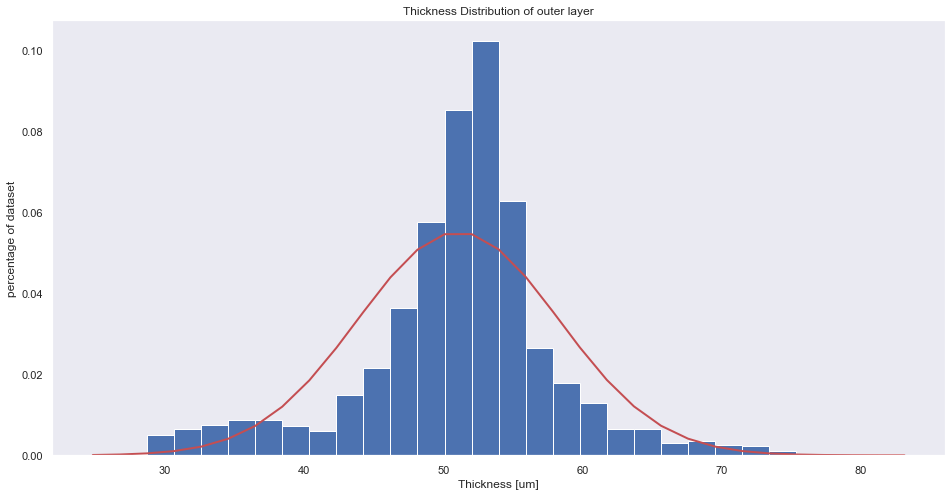

In [7]:
mu = labels["Thickness"].mean()
sigma = labels["Thickness"].std()
sigma = sigma
s = labels["Thickness"]
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Thickness [um]')
plt.ylabel('percentage of dataset')
plt.title("Thickness Distribution of outer layer")
plt.show()

## Functions

In [8]:
def get_path_and_image_name(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img=Image.open(file_path)
    #img = resize(img, (1750, 1750), anti_aliasing=True)
    return np.array(img)


In [9]:
def get_path_and_image_name_resized(df, Image_ID, size):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img = imread(file_path)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.array(img)


In [10]:
def get_file_path(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    return file_path

<Figure size 1080x792 with 0 Axes>

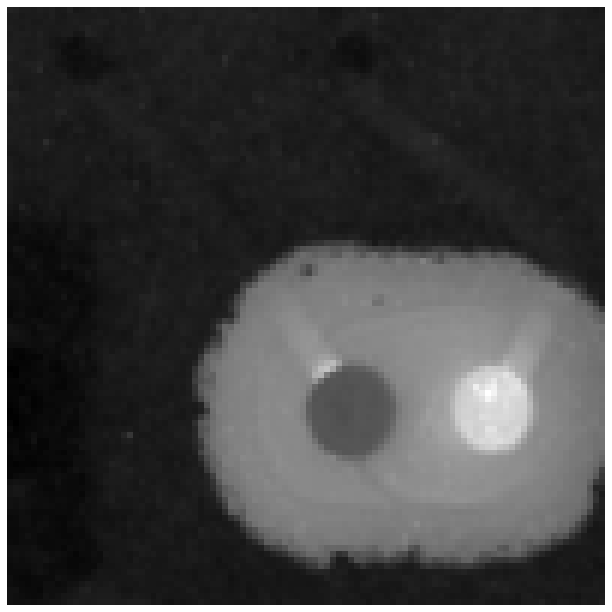

In [11]:
#A image of one of the discarded sensors
plt.figure(figsize=(15, 11))
temp = 6*75
image = imread(get_file_path(labels,temp), as_gray=True)
#4, 153, 37, 11, 12, 110, 129, 9, 36, 40, 42, 65, 0
# print('image shape before',image.shape)
# plt.imshow(image, cmap='gray')
# plt.title("a discarded sensor")
# plt.axis('off')
# plt.show()

image = resize(image, (100, 100), anti_aliasing=True)


plt.figure(figsize=(15, 11))
plt.imshow(image, cmap='gray')
#plt.title("Approved sensor, silicone")
plt.axis('off')
#plt.savefig('IMG_test')
plt.show()





#image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
#                       anti_aliasing=True)

## Cropping

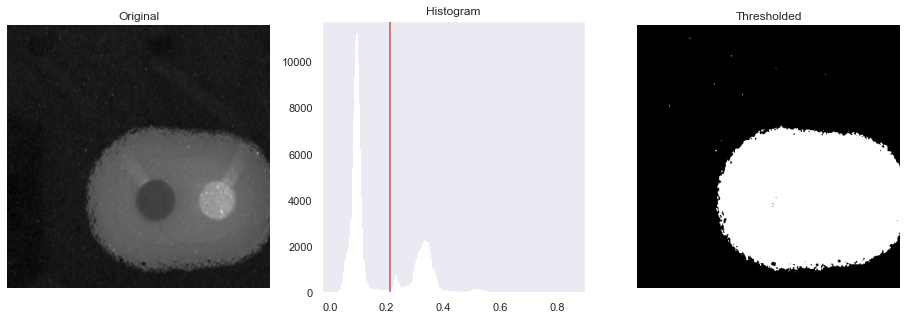

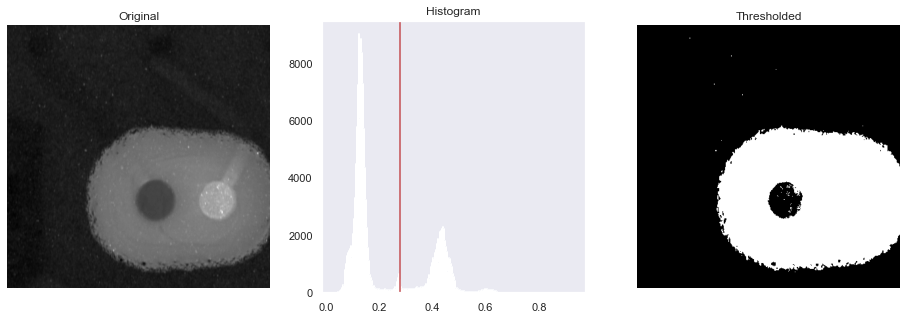

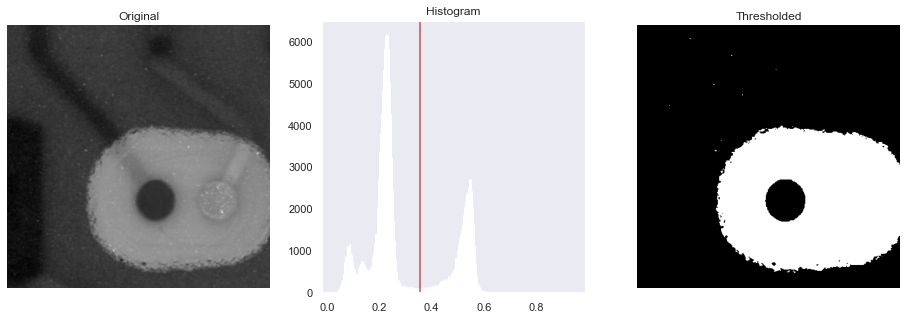

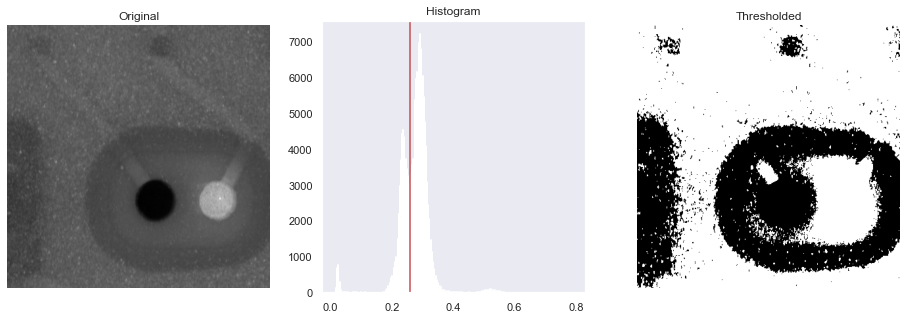

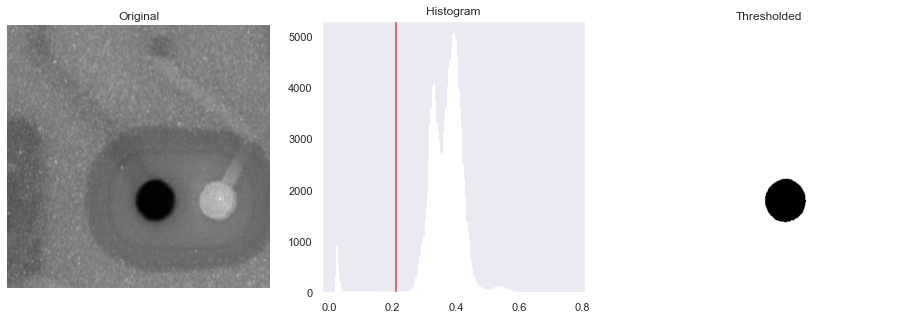

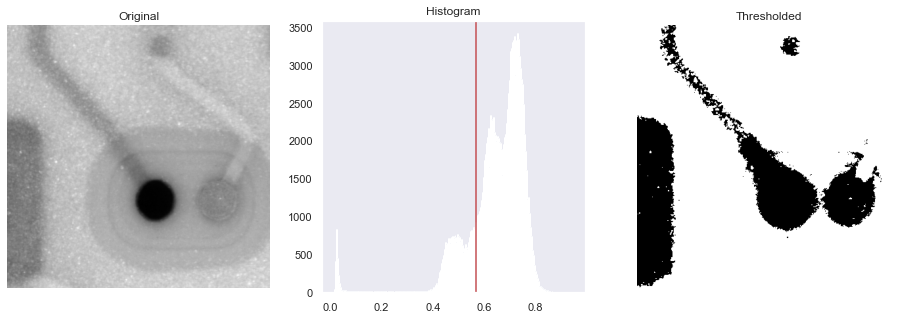

In [12]:
for img_id in range(6):
    image = get_path_and_image_name(labels, (70*6)+img_id) #300 - tush marker, #54 - total smushed sensor,
    image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(16, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    plt.show()


In [13]:
def crop_image(img_id, tol=0): # not used
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [14]:
def get_crop_mask(img_id, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask1', mask)
    #return image[np.ix_(mask.any(1),mask.any(0))]
    return mask

In [15]:
def crop_image2(img_id, Mask, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    mask = Mask
    #print('mask2', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [16]:
def get_shape_in_mm(image):
    res = 0.0021
    print('width:', image.shape[0]*res)
    print('length:', image.shape[1]*res)

## Feauture extraction

In [17]:
def create_feature_matrix_stacked(label_df,hog_size):
    
    features_list = []
    image_features_stacked = []
    for img_id in range(len(labels)): #Iterate over DataFrame (label_df.index-6)
        #print('img_id',img_id)
        if (img_id % 200) == 0:
            print('Date/Time', datetime.now(),'-------Image ID', img_id)
            
        if label_df.iloc[img_id,2] == 1: #if this is the first band, proceed
            root_image = img_id #define root image
            image_features_stacked = [] # create/reset list
            
            #Generate cropping mask, extracted from the third band(imperic tested)
            #mask = get_crop_mask(root_image + 2)
    
            
            #print('Root image:', root_image) #just to keep track while running
            for band in range(6): #Iteration over bands
                #image = crop_image2(img_id, mask)
                image = get_path_and_image_name(labels, img_id)
                image = resize(image, (150, 150), anti_aliasing=True)
                
                #print('band:', band)
                image_features =  hog(image, block_norm='L2-Hys', pixels_per_cell=(hog_size, hog_size)) #Generate image features
                image_features_stacked = np.hstack((image_features_stacked, image_features))

                #stack images
                if band == 5: # stack the image features when the all bands has been processed
                    features_list.append(image_features_stacked)
                    #print('shape of features list', len(features_list))
                    
                
     # convert list of arrays into a matrix
    features_matrix = np.array(features_list)               
                    
    return features_matrix
    


In [18]:
def load_or_generate_hog(labels, hog_size, load=False):
    print('were gonna print this shit')
    name = 'feature_matrix_thickness_estimation' + str(hog_size) +'.csv'
    print(name)
    if load == True:
        temp = np.asarray(pd.read_csv(name, header=None))
        temp = pd.DataFrame(temp)
        print('File loaded as:', name)
        
    else:
        temp = create_feature_matrix_stacked(labels, hog_size)
        #np.savetxt(name, temp, delimiter=",")
        #pd.DataFrame(temp)
        print('SAVE IS DISABLED.....File saved as:', name)
    return temp
        

In [19]:
# #Call the function
#feature_matrix = create_feature_matrix_stacked(labels, 100)
feature_matrix = load_or_generate_hog(labels,20, load=False)

were gonna print this shit
feature_matrix_thickness_estimation20.csv
Date/Time 2020-06-11 12:35:37.476689 -------Image ID 0
Date/Time 2020-06-11 12:36:48.679634 -------Image ID 200
Date/Time 2020-06-11 12:38:00.042983 -------Image ID 400
Date/Time 2020-06-11 12:39:09.389486 -------Image ID 600
Date/Time 2020-06-11 12:40:21.666885 -------Image ID 800
Date/Time 2020-06-11 12:41:30.200426 -------Image ID 1000
Date/Time 2020-06-11 12:42:42.289239 -------Image ID 1200
Date/Time 2020-06-11 12:43:52.907018 -------Image ID 1400
Date/Time 2020-06-11 12:45:02.049320 -------Image ID 1600
Date/Time 2020-06-11 12:46:11.005566 -------Image ID 1800
Date/Time 2020-06-11 12:47:24.719210 -------Image ID 2000
Date/Time 2020-06-11 12:48:33.200864 -------Image ID 2200
Date/Time 2020-06-11 12:49:41.538861 -------Image ID 2400
Date/Time 2020-06-11 12:50:52.989692 -------Image ID 2600
Date/Time 2020-06-11 12:52:01.761192 -------Image ID 2800
Date/Time 2020-06-11 12:53:10.535660 -------Image ID 3000
Date/Time 

In [20]:
#Get the dimensions of the data frame
feature_matrix_df = pd.DataFrame(feature_matrix)
dims=feature_matrix_df.shape
# feature_matrix.shape
# print('rows in DF', dims[0])
# print('columns in DF', dims[1])
#feature_matrix_df = pd.DataFrame(list(feature_matrix))
feature_matrix_df.head()

#feature_matrix_df.drop(feature_matrix_df.tail(600).index,inplace=True)
length = feature_matrix_df.shape[0]
print('shape', feature_matrix_df.shape)

shape (1359, 12150)


In [21]:
#Standardize feature matrix

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
FMS = ss.fit_transform(feature_matrix_df) #Feature Matrix Standardized
FMS = pd.DataFrame(FMS) 
FMS.head()


,0,1,2,3,4,5,6,7,8,9,...,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149
0,-1.247192,-0.045635,0.525879,-0.122103,-0.235586,-0.024652,-0.759850,-0.735792,0.125668,-2.250501,...,0.104635,-0.101737,-1.047006,-1.641281,-1.293603,-0.840954,0.206681,0.189914,0.187086,-0.411931
1,-1.084204,-1.074357,-1.345117,-0.425855,-1.075895,0.936089,-0.286679,0.661174,1.196055,-0.588384,...,1.449570,-0.136155,-1.124113,-1.510092,-1.402902,-0.910838,-0.309569,0.490815,1.691781,0.909941
2,-0.712978,-0.415391,-1.796422,0.310839,-0.988256,0.431191,-0.617105,0.146381,0.144656,-0.519747,...,-0.622788,-0.966049,-0.926596,-1.568525,-1.422171,-0.763793,-0.224113,1.523145,1.393142,2.409038
3,-0.805159,0.140356,0.422593,0.317909,-1.595446,0.059247,-1.306702,-1.257522,-0.224146,-1.565061,...,0.005130,-0.670927,-1.027497,-1.630298,-1.518176,-0.877798,0.509059,0.834396,1.242353,0.494444
4,0.419671,-1.185293,-1.302330,-0.125545,-0.568799,1.745427,-0.582415,1.241189,-0.753681,0.154056,...,1.109690,-0.447982,-1.235737,-1.654094,-1.443141,-0.961127,-0.463286,-0.194380,0.431804,-0.150531


In [22]:
#Explained variance

FMS_pca = PCA() #Feature Matrix Standadized(FMS)_PCA
FMS_pca = FMS_pca.fit(FMS)

tot = sum(FMS_pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(FMS_pca.explained_variance_, reverse=True)]
pc_title=['PC %s' %i for i in range(1,dims[1])]

#for cname, val in zip(pc_title, var_exp):
    #print("%s = %.2f"%(cname, val))

cum_var_exp = np.cumsum(var_exp)
print('cum_car_exp',cum_var_exp)

# plt.plot(cum_var_exp)
# plt.title('Explained variance by different principal components')
# plt.ylabel('Explained variance in percent')
# plt.xlabel('Principal components')
# plt.grid()
# plt.show()

cum_car_exp [ 18.77913398  31.75420879  42.71489221 ...  99.99999776 100.
 100.        ]


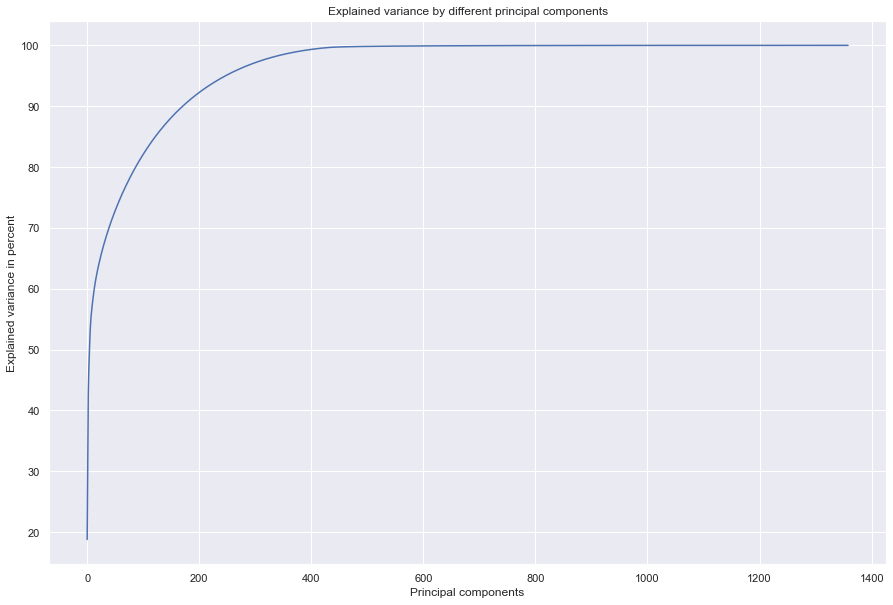

In [23]:

plt.plot(cum_var_exp)
plt.title('Explained variance by different principal components')
plt.ylabel('Explained variance in percent')
plt.xlabel('Principal components')
plt.grid()
plt.show()

In [24]:
#PCA
#Lifehack: 6 components for HOG-size=500, 83 for HOG_size 100, 101 for HOG_size 50
n_pca_components = 500 #length #216
FMS_pca = PCA(n_components=(n_pca_components)) #Feature Matrix Standadized(FMS)_PCA
FMS_pca = FMS_pca.fit_transform(FMS)
FMS_pca = pd.DataFrame(FMS_pca)
print('shape of Feature Matrix standardized Principal Component Analasys', FMS_pca.shape)
#FMS_pca.head()

shape of Feature Matrix standardized Principal Component Analasys (1359, 500)


In [25]:
# #Saving the PCA frame
# name = 'PCA_thickness_estimation.csv'
# np.savetxt(name, FMS_pca, delimiter=",")

In [26]:
# temp = pd.read_csv("PCA_thickness_estimation.csv", sep=',')
# temp = pd.DataFrame(temp)
# temp.head()

## Split and train

In [27]:
#making the labels_df that corresponds to the stacked images

labels_stacked = labels.set_index('Sensor_ID')
labels_stacked = labels_stacked[labels_stacked.Band == 1]
labels_stacked = labels_stacked.drop(["New Name", "Path", "Band", "Label"], axis = 1)
labels_stacked.describe()
#print('shape', labels_stacked.shape)


,Thickness
count,1359.000000
mean,51.077879
std,7.249460
min,24.812000
25%,48.319000
50%,51.851000
75%,54.478500
max,83.148000


In [28]:
#X datasaet for classification - Features
X_class = FMS_pca
#X_class = FMS
X_class.shape

(1359, 500)

In [29]:
# y dataset for classification - labels feature_matrix_df.drop(feature_matrix_df.tail(300).index,inplace=True)
y_class = pd.DataFrame(labels_stacked['Thickness'])
#y_class.drop(y_class.tail(600).index,inplace=True)
y_class.head()

,Thickness
Sensor_ID,
0,56.912
1,51.620
2,48.034
3,44.931
4,43.242


In [30]:
y_class = y_class.to_numpy()

Markdown, maybe the decimals is a bit overkill, lets round the thickness label, lets round them

In [31]:
# from sklearn.svm import SVR

# # clf = SVR(C=1.0, epsilon=0.2)
# # clf.fit(X_class, y_class)
# # clf.score
# kf = KFold(n_splits=5, random_state=42, shuffle=True)

# #kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for train_index, test_index in kf.split(X_class, y_class):
#     #-------Splitting-------------
#     #print("TEST SET", test_index)
        
#     X_train = X_class.iloc[train_index]
#     X_test  = X_class.iloc[test_index]
#     y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
#     #----------Training------------
#     clf = SVR(C=1.0, epsilon=0.2)
#     clf.fit(X_train, y_train)
#     train_score.append(clf.score(X_train, y_train))
#     test_score.append(clf.score(X_test, y_test))
#     y_pred = clf.predict(X_test)
#     #print('----------')
#     #print('y_pred:',y_pred)
#     accuracy = (y_test, y_pred)
#     accuracy_list.append(accuracy_score(y_test, y_pred))
#     confusion_matrix(y_test, y_pred)
    
# mean_test  = np.mean(test_score)
# std_test   = np.std(test_score)

# mean_train = np.mean(train_score)
# std_train  = np.std(train_score)


# # mean_acc   = np.mean(accuracy_list)
# # std_acc    = np.std(accuracy_list)

# print('-------Train score--------')
# print('Mean:', mean_train)
# print('Std. Deviation:', std_train)
# print('--------Test score---------')
# print('Mean:', mean_test)
# print('Std. Deviation', std_test)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.33, random_state=42)


#model
regr = SVR(kernel='linear', gamma='scale', epsilon =0.0001)

# train
regr.fit(X_train, y_train)

# test
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



C:\Users\caspe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error: 41.13
Coefficient of determination: 0.13


In [33]:
prediction = pd.DataFrame(y_pred, columns = ['prediction'])
prediction[('test')]=y_test
prediction[('diff')]=prediction[('test')]-prediction[('prediction')]
prediction=prediction.sort_values(by=['test'])
prediction = prediction.reset_index()
prediction.head()

,index,prediction,test,diff
0,416,73.911870,24.812,-49.099870
1,433,45.890137,28.912,-16.978137
2,295,55.953430,28.942,-27.011430
3,13,25.058555,30.721,5.662445
4,187,36.086255,31.180,-4.906255


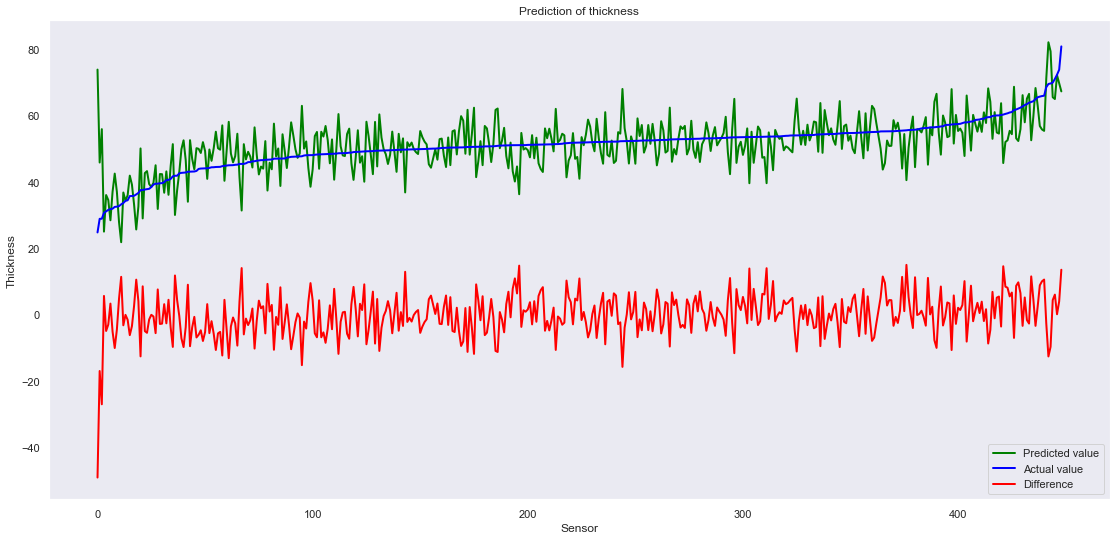

In [39]:
prediction = pd.DataFrame(y_pred, columns = ['prediction'])
prediction[('test')]=y_test
prediction[('diff')]=prediction[('test')]-prediction[('prediction')]
prediction=prediction.sort_values(by=['test'])
prediction = prediction.reset_index()
prediction.head()


plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction[('prediction')]
data2 = prediction[('test')]
data3 = prediction[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
ax1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
#ax1.set_ylim(bottom=-21, top=21)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('temp.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.33, random_state=42)



regr = linear_model.LinearRegression()

# train
regr.fit(X_train, y_train)

# test
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



Mean squared error: 31.52
Coefficient of determination: 0.33


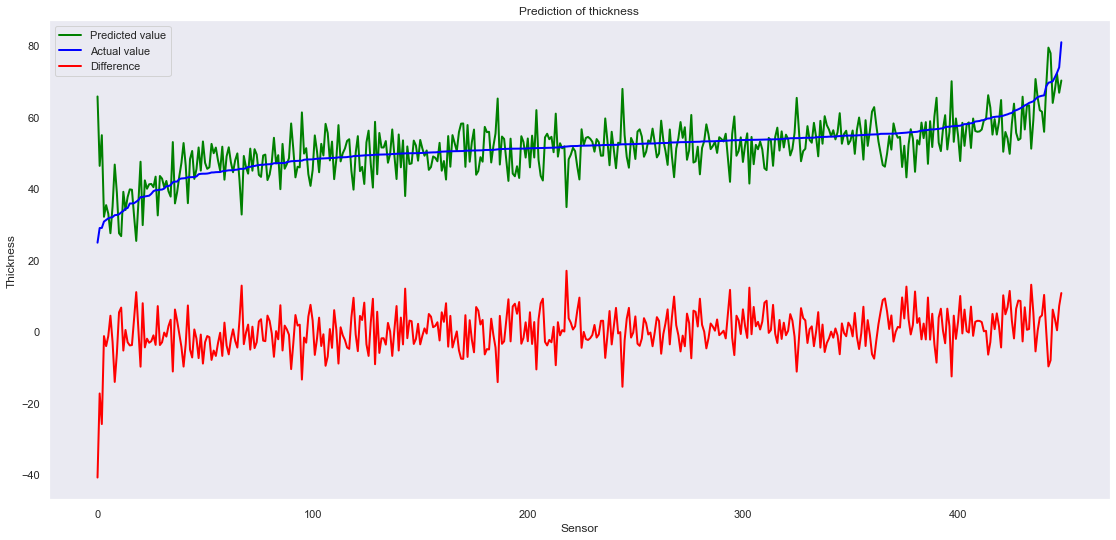

In [47]:
prediction2 = pd.DataFrame(y_pred, columns = ['prediction'])
prediction2[('test')]=y_test
prediction2[('diff')]=prediction2[('test')]-prediction2[('prediction')]
prediction2=prediction2.sort_values(by=['test'])
prediction2 = prediction2.reset_index()
prediction2.head()


plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction2[('prediction')]
data2 = prediction2[('test')]
data3 = prediction2[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
ax1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
#ax1.set_ylim(bottom=-21, top=21)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('linear_regrssion_r2_0_33.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.33, random_state=42)



regr = linear_model.SGDRegressor()

# train
regr.fit(X_train, y_train)

# test
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



Mean squared error: 16185976275456324704141312.00
Coefficient of determination: -342172320264349112336384.00


C:\Users\caspe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


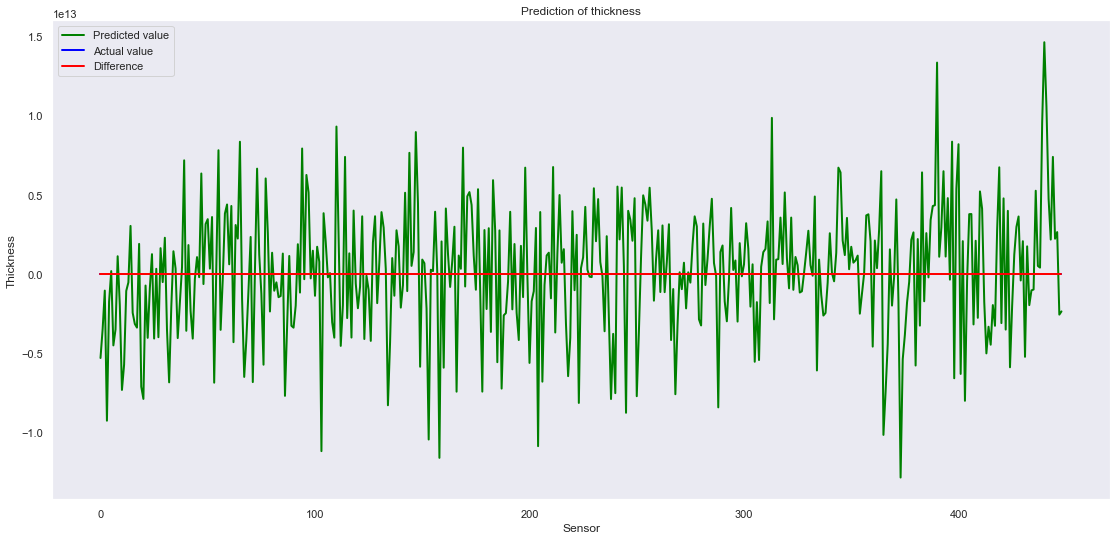

In [50]:
prediction3 = pd.DataFrame(y_pred, columns = ['prediction'])
prediction3[('test')]=y_test
prediction3[('diff')]=prediction3[('test')]-prediction2[('prediction')]
prediction3=prediction3.sort_values(by=['test'])
prediction3 = prediction3.reset_index()
prediction3.head()


plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction3[('prediction')]
data2 = prediction3[('test')]
data3 = prediction3[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
ax1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
#ax1.set_ylim(bottom=-21, top=21)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('SGD_regressor_r2_-20000000000.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.33, random_state=42)



regr = linear_model.LogisticRegression()

# train
regr.fit(X_train, y_train)

# test
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



C:\Users\caspe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

In [52]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.33, random_state=42)



regr = KNeighborsRegressor()

# train
regr.fit(X_train, y_train)

# test
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



Mean squared error: 18.42
Coefficient of determination: 0.61


In [53]:
prediction = pd.DataFrame(y_pred, columns = ['prediction'])
prediction[('test')]=y_test
prediction[('diff')]=prediction[('test')]-prediction[('prediction')]
prediction.head()

,prediction,test,diff
0,39.9154,44.115,4.1996
1,56.5582,71.091,14.5328
2,50.0770,53.149,3.0720
3,53.6698,51.350,-2.3198
4,54.8752,63.219,8.3438


In [54]:
prediction=prediction.sort_values(by=['test'])
prediction = prediction.reset_index()
prediction.head()

,index,prediction,test,diff
0,416,52.7142,24.812,-27.9022
1,433,42.4494,28.912,-13.5374
2,295,48.0030,28.942,-19.0610
3,13,34.9562,30.721,-4.2352
4,187,47.7924,31.180,-16.6124


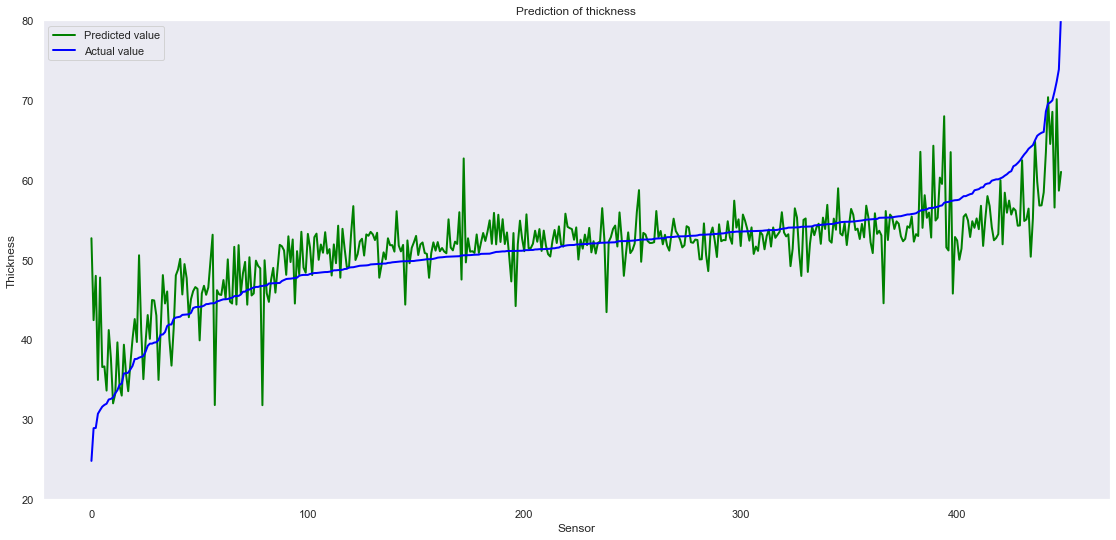

In [58]:
plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction[('prediction')]
data2 = prediction[('test')]
data3 = prediction[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
#ax1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
ax1.set_ylim(bottom=20, top=80)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('KNN_r2_0_61.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [59]:

import numpy as np
import pandas as pd
import keras
import keras.backend as kb
import tensorflow as tf

Using TensorFlow backend.


In [60]:
#Standarize test and train
y_test_max = y_test.max()
y_train_max = y_train.max()

print('maximum in test set:', y_test_max)
print('maximum in train set:', y_train_max)
ss = StandardScaler()
# run this on our feature matrix



y_test = pd.DataFrame(ss.fit_transform(y_test))
y_train = pd.DataFrame(ss.fit_transform(y_train))
y_test.head()

maximum in test set: 80.906
maximum in train set: 83.148


,0
0,-1.031127
1,2.891081
2,0.282382
3,0.020815
4,1.746522


In [61]:
y_train.head()

,0
0,0.073404
1,0.279567
2,0.324708
3,-0.414921
4,-0.311839


In [62]:
input_shape=[len(X_train.keys())]
print(input_shape)

[500]


In [66]:
model = keras.Sequential([
    keras.layers.Dense(500, activation=tf.nn.relu, input_shape=[500]),
    keras.layers.Dense(500, activation=tf.nn.relu),
    keras.layers.Dense(250, activation=tf.nn.relu),
    keras.layers.Dense(250, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

In [67]:
#history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=1, batch_size =2)

Train on 910 samples, validate on 449 samples
Epoch 1/40
910/910 [==============================] - 1s 1ms/step - loss: 1460390.7290 - val_loss: 1.1418
Epoch 2/40
910/910 [==============================] - 0s 456us/step - loss: 1.4765 - val_loss: 1.0733
Epoch 3/40
910/910 [==============================] - 0s 493us/step - loss: 0.9928 - val_loss: 1.0703
Epoch 4/40
910/910 [==============================] - 0s 447us/step - loss: 0.9998 - val_loss: 0.9647
Epoch 5/40
910/910 [==============================] - 0s 482us/step - loss: 0.9731 - val_loss: 0.6253
Epoch 6/40
910/910 [==============================] - 0s 473us/step - loss: 0.8404 - val_loss: 0.8387
Epoch 7/40
910/910 [==============================] - 0s 482us/step - loss: 0.9153 - val_loss: 0.8513
Epoch 8/40
910/910 [==============================] - 0s 477us/step - loss: 1.3702 - val_loss: 0.9667
Epoch 9/40
910/910 [==============================] - 0s 403us/step - loss: 0.9501 - val_loss: 0.8467
Epoch 10/40
910/910 [===========

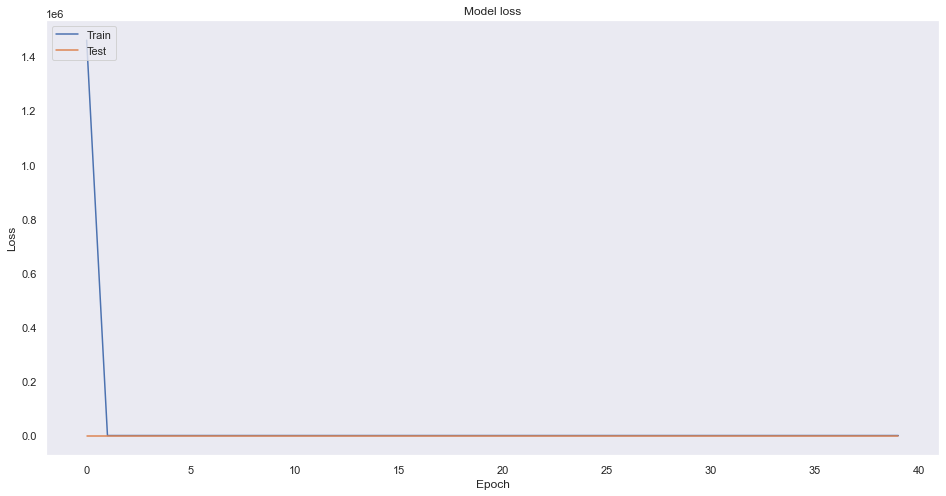

In [68]:
optimizer = tf.keras.optimizers.RMSprop(0.0099)
model.compile(loss='mean_squared_error',optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=40, batch_size =32)

# Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#opt = RMSprop(learning_rate=0.001, rho=0.9)

In [69]:
preds = model.predict(X_test)

NameError: name 'a' is not defined

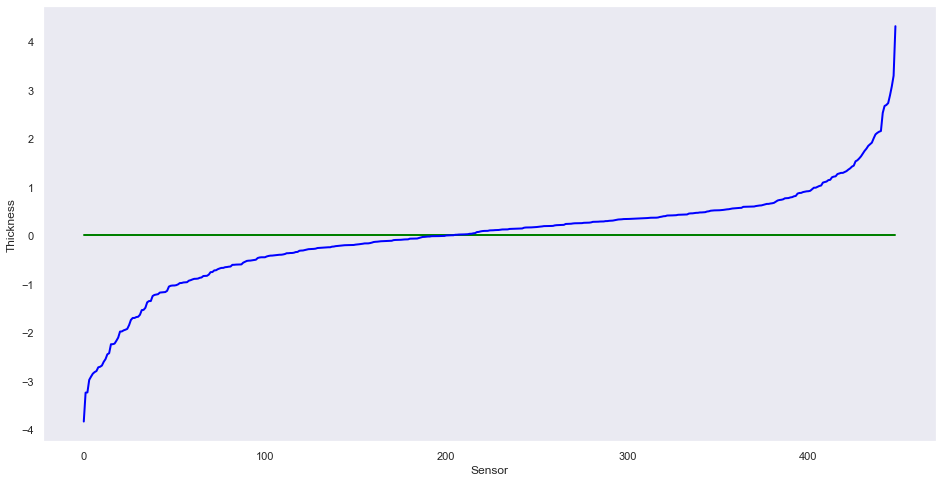

In [72]:
prediction4 = pd.DataFrame(preds, columns = ['prediction'])
prediction4[('test')]=y_test
prediction2[('diff')]=prediction4[('test')]-prediction2[('prediction')]
prediction4=prediction4.sort_values(by=['test'])
prediction4 = prediction4.reset_index()
prediction4.head()


plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction4[('prediction')]
data2 = prediction4[('test')]
#data3 = prediction4[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
a#x1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
#ax1.set_ylim(bottom=-21, top=21)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('linear_regrssion_r2_0_33.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [ ]:
#model = build_model()

In [ ]:
# build_model  function() {
  
#   model <- keras_model_sequential() %>%
#     layer_dense(units = 64, activation = "relu",
#                 input_shape = dim(train_data)[2]) %>%
#     layer_dense(units = 64, activation = "relu") %>%
#     layer_dense(units = 1)
  
#   model %>% compile(
#     loss = "mse",
#     optimizer = optimizer_rmsprop(),
#     metrics = list("mean_absolute_error")
#   )
  
#   model
# }

# model <- build_model()
#model %>% summary()

# TO DO
- Making the model
    - statistics
    - Outlier detection

